# Report
This notebook gives some insights of the simulation.
 To get insight of the households usn.py must include the option *--verbose* which generate a text file containing information of the household in the main usn directory.
Each time usn.py is launched, the user should:

1 - Paste the household output (namely household\_output\_\*.txt) into an ouput dir AND renaming the file BF\_\*.txt where \* is a RGN.

2 - Rename the generated graph (sb_graph.pickle) into sb_graph_\*.pickle where \* is the same RGN according to point 1

## Example
`$ python usn.py -c config/config.ini -o outdir/ --verbose
$ ls household_output*.txt
 --> household_output_12345.txt
$ mv household_output_12345.txt outdir/BF_12345.txt
$ mv outdir/sb_graph.pickle outdir/sb_graph_12345.pickle
`
## Input parameters:


main_dir: the **absolute path** to the main directory of the repository.

out_dir: the directory where the images are saved - relative to main_dir

simulation_output_dir: the directory where both the graphs and household output - relative to main_dir

In [48]:
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np
import igraph as ig
import configparser as cp
import six
import pickle
from PIL import Image
import collections
from scipy.sparse import csr_matrix, coo_matrix
from config import GROUP_NAMES
from libfunc import read_from_config

In [49]:
main_dir = "../"
out_dir = "./resources/"
simulation_output_dir = '../data/graphs/firenze/deg10_ep05_1000m_min10pop/'

#os.chdir(main_dir)
data_config = "../config/config_firenze_1000m_ep05.ini"
data_household_noheader = '../BuildSBG/hhfamilyprob_noheader_with_various.csv'
data_households_role = '../BuildSBG/hhroleprob.csv'
city = read_from_config(data_config, 'CITY', 'city')
data_pop = '../data/population/{}/population_{}.csv'.format(city, city)
territory_data='../data/population/{}/territory_projected.pickle'.format(city)


In [50]:
sns.set_theme('paper')
RC_GLOBAL = {'axes.facecolor':'white', 'axes.edgecolor': 'black', 'figure.facecolor':'white', "patch.facecolor": "navy", "image.cmap": "Blues", "axes.titlesize": 20, "axes.labelsize": 10} 
city = read_from_config(data_config, 'CITY', 'city')
if os.path.exists(out_dir) is False: os.mkdir(out_dir)

In [51]:
def get_files_list(directory, filestring):
    files = []
    for filename in os.listdir(directory):
        if filestring in filename:
            files.append(os.path.join(directory, filename))
    return files

def get_run_id(filename, string):
    name = os.path.basename(filename)
    run = name.split(string+'_')[1].split('.')[0]
    return run

In [52]:
graph_files = get_files_list(simulation_output_dir, 'graph')
bf_out_files = get_files_list(simulation_output_dir, 'BF')

In [53]:
def plot_input_ages_distribution(data_pop, box_name, box_aspect=None):

    #Make the DataFrame with the right format
    pop_dataframe = pre_process_data_pop(data_pop)
    #Plot the DataFrame
    ax = get_age_distribution_ax(pop_dataframe, box_aspect, title="Distribution of ages - Input")
    #Save the DataFrame
    format_and_save(box_name)

def get_age_distribution_ax(pop_dataframe, box_aspect, title=""):
    hue_order = [get_age_strings()[i] for i in range(len(get_age_strings())-1, -1, -1)]
    ax = set_aspect(box_aspect)
    g = sns.histplot(data=pop_dataframe, 
                     x="dummy", 
                     stat='probability', 
                     hue='Age group',
                     hue_order=hue_order,
                     multiple='stack', 
                     palette='viridis',
                     legend=False,
                     ax=ax
                    )
    #Decorations
    g = set_ages_text(g)
    g.set_xticklabels("")
    locmin = mticker.LinearLocator(11)
    g.yaxis.set_major_locator(locmin)
    g.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.02f'))
    g.set_title(title)
    g.set_xlabel("")
    g.set_ylabel("Probability")
    g.axes.grid(True,which="major",ls="-",c='gray',axis='y')
    
def set_ages_text(g):
    #Applying strings on patches
    g.set_ylim(0,1)
    for string, rect in zip(get_age_strings(), g.axes.patches):
        ((x0, y0), (x1, y1)) = rect.get_bbox().get_points()
        x = (x1-x0)/2+x0
        y = (y1-y0)/2+y0
        g.axes.text(x,y,string.title(), horizontalalignment='center', verticalalignment='center',color='white')
    return g    
    
def pre_process_data_pop(data_pop):
    pop_dataframe = pd.read_csv(data_pop)
    pop_dataframe['dummy'] = 0 #Helper for the plot
    pop_dataframe = pop_dataframe.rename(columns={'type': 'Age group'})
    #Get the ages' list and translate them (e.g. 0-> children, 1-> young, ... according to get_age_string_function)
    translate_list = get_age_strings()
    for i in range(len(translate_list)):
        pop_dataframe['Age group'] = pop_dataframe['Age group'].replace(i, translate_list[i])

    return pop_dataframe

def get_age_strings():
    #list is read from configuration file
    return GROUP_NAMES

def format_and_save(box_name):
    sns.set(rc=RC_GLOBAL)
    path = os.path.join(out_dir, box_name)
    print(path)
    plt.savefig(path, dpi=300, bbox_inches='tight')
    
def set_aspect(box_aspect):
    plt.cla()
    if box_aspect is None:
        ax=None
    else:  
        _, ax = plt.subplots()
        ax.set_aspect(box_aspect)
    return ax

In [54]:
plot_input_ages_distribution(data_pop, "C_in.pdf")

./resources/C_in.pdf


In [55]:
def plot_output_ages_distribution(bf_out_files, box_name, box_aspect=None):

    #Make the DataFrame with the right format
    age_stats_whole_run = pd.DataFrame()
    for bf_out_file in bf_out_files:
        age_stats_whole_run = age_stats_whole_run.append(get_age_series_from_run(bf_out_file), ignore_index=True)
    #Plot the DataFrame
    ax = get_age_distribution_ax(age_stats_whole_run, box_aspect, title="Distribution of ages - Output")
    #Save the DataFrame
    format_and_save(box_name)

def count_actors_assigned_to_household(bf_out_file, query_columns, as_series=False):
    columns = ['agent_id', 'family_id', 'tile_id', 'age_group', 'role', 'done_flag', 'parent_id', 'peer_id', 'child_1', 'child_2', 'child_3', 'child_4', 'child_5', 'num_c_ud']    
    bf_df = pd.read_csv(bf_out_file, sep=' ', names=columns)
    families_df = bf_df[bf_df.done_flag == 1]

    #The age group column is traslated into the right format: c->children, a->adults, ...
    rename_ages = {strg[0] : strg for strg in get_age_strings()}
    families_df = families_df.replace({"age_group": rename_ages})
    couting_df = families_df.groupby(query_columns).count().iloc[:,0]
    
    if as_series is True: return couting_df
    couting_df = couting_df.to_frame().reset_index()
    couting_df = rename_columns_counting_df(couting_df, query_columns)
    return couting_df

def get_age_series_from_run(bf_out_file):
    age_stats_run = count_actors_assigned_to_household(bf_out_file, ['age_group'], as_series=False)
    age_stats_run = age_stats_run.rename(columns={'age_group': 'Age group'})
    age_stats_run['dummy'] = 0

    return age_stats_run

def rename_columns_counting_df(df, query_columns):
    old_column_names = df.columns.to_list()
    new_column_names = query_columns + ['values']
    rename_dict = {old_column_names[i]: new_column_names[i] for i in range(len(new_column_names))}
    return df.rename(columns=rename_dict)

In [56]:
plot_output_ages_distribution(bf_out_files, "C_out.pdf")

ValueError: Could not interpret value `dummy` for parameter `x`

In [57]:
def plot_input_households_distribution(data_household_noheader, box_name, box_aspect=None):
    family_dataframe = get_household_input_data(data_household_noheader)
    stacking_entries = sorted(family_dataframe.columns.to_list())
    family_dataframe['x'] = 0
    ax = set_aspect(box_aspect)
    ax = stacked_barplot(family_dataframe, 'x', stacking_entries, ax=ax)
    ax = set_decoration_household_distribution(ax, stacking_entries, title="Distribution of households - Input")
    format_and_save(box_name)

def stacked_barplot(df, x_col_name, stacking_order, palette='viridis', legend=False, y_margin=0.05, force_y_bound=None, ax=None):
    tot_entries = len(stacking_order)
    pal = sns.color_palette(palette, tot_entries)
    colors = pal.as_hex()
    tot_rows = df[x_col_name].nunique()
    for ind, data in enumerate(stacking_order):
        if legend is True: label = data
        else: label = None
        g = sns.barplot(data=df, x=x_col_name, y=data,color=colors[ind], label=label, ax=ax)

    y0 = [0 for row in range(tot_rows)]
    row = 0
    for patch, line in zip(g.axes.patches, g.axes.lines):
        x0, _= patch.get_xy()
        w = patch.get_width()
        h = patch.get_height()
        patch.set_bounds(x0, y0[row], w, h)
        y0line, y1line = line.get_ydata()
        line.set_ydata([y0line+y0[row], y1line+y0[row]])
        y0[row] += h
        row += 1
        if row == tot_rows: row=0
    
    zorder = 100
    for line in g.axes.lines:
        line.set_zorder(zorder)
        
    y0line, y1line = line.get_ydata()
    y0max=max(y0)
    if pd.isna(y1line): g.set_ylim(0,y0max*(1+y_margin))
    else: 
        if (y1line > y0max): y_bound = y1line
        else: y_bound=y0max
        g.set_ylim(0,y_bound*(1+y_margin))
    if force_y_bound is not None:
        ymax=y0
        y0 = [0 for row in range(tot_rows)]
        ratio = [force_y_bound/y for y in ymax]
        row = 0
        for patch, line in zip(g.axes.patches, g.axes.lines):
            x0, _= patch.get_xy()
            w = patch.get_width()
            h = patch.get_height()
            patch.set_bounds(x0, y0[row], w, h*ratio[row])
            y0line, y1line = line.get_ydata()
            line.set_ydata([y0line*ratio[row], y1line*ratio[row]])
            y0[row] += h*ratio[row]
            row += 1
            if row == tot_rows: row=0
            zorder = 100
        for line in g.axes.lines:
            line.set_zorder(zorder)

        y0line, y1line = line.get_ydata()
        y0max=max(y0)
        if pd.isna(y1line): g.set_ylim(0,y0max*(1+y_margin))
        else: 
            if (y1line > y0max): y_bound = y1line
            else: y_bound=y0max
            g.set_ylim(0,y_bound*(1+y_margin))
    if legend is True: g.legend()
    return g

def get_household_input_data(data_household_noheader):
    family_dataframe = pd.read_csv(data_household_noheader)
    family_dataframe['Type'] = family_dataframe['Type'].apply(lambda x: x[0:-1])
    family_dataframe = family_dataframe.groupby('Description').sum().reset_index()
    family_dataframe['run'] = 1
    family_dataframe = family_dataframe.pivot(index='run', columns='Description', values='Probability')
    return family_dataframe

def set_decoration_household_distribution(ax, stacking_entries=None, title="", xlabel=False, force_y_lim=True):
    if stacking_entries is not None:
        hue_order = stacking_entries
        rects = ax.axes.patches
        y0 = 0
        for string, rect in zip(hue_order, rects):
            ((x0, _), (x1, y1)) = rect.get_bbox().get_points()
            x = (x1-x0)/2+x0
            y = (y1-y0)/2+y0
            y0 = y1
            ax.axes.text(x,y,string.title(), horizontalalignment='center', verticalalignment='center', color='white')
    locmin = mticker.LinearLocator(11)
    ax.yaxis.set_major_locator(locmin)
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.02f'))
    # locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=1)
    ax.set_ylabel("Probability")
    if xlabel is False:
        ax.xaxis.set_major_locator(mticker.NullLocator())
        ax.set_xlabel("")
    if force_y_lim is True: ax.set_ylim(0,1)
    ax.axes.grid(True,which="major",ls="-",c='gray',axis='y')
    ax.set_title(title)
    return ax

./resources/D_in.pdf


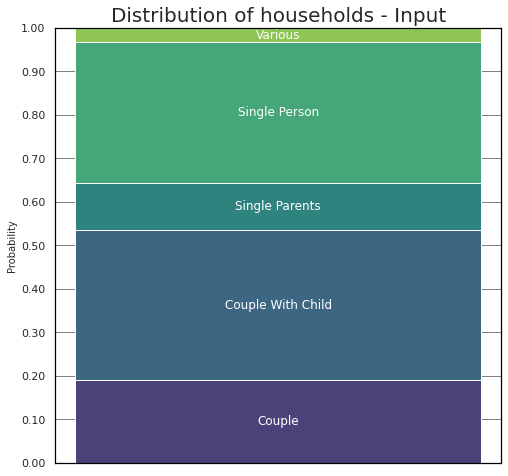

In [58]:
plot_input_households_distribution(data_household_noheader, "D_in.pdf")

In [59]:
def plot_output_households_distribution(bf_out_files, box_name, box_aspect=None):
    
    family_dataframe_run = get_household_stats_whole_simulation(bf_out_files)
    family_dataframe_run['x']=0
    family_dataframe_run = family_dataframe_run.set_index('run')
    stacking_entries = sorted(family_dataframe_run.columns.to_list())
    stacking_entries.remove('x')
    ax = set_aspect(box_aspect)
    ax = stacked_barplot(family_dataframe_run, 'x', stacking_entries, ax=ax, force_y_bound=1)
    ax = set_decoration_household_distribution(ax, stacking_entries, title="Distribution of households - Output", force_y_lim=False)
    format_and_save(box_name)
def get_household_stats_whole_simulation(bf_out_files):
    family_dataframe_run = pd.DataFrame()
    
    for ind, bf_out_file in enumerate(bf_out_files):
        bf_df = get_bf_out(bf_out_file)
        bf_df = bf_df[bf_df.done_flag == 1]
        family_dataframe_this_run = get_household_stats_run(bf_df)
        [family_dataframe_this_run.pop(key) for key in get_age_strings()]
        family_dataframe_this_run = pd.DataFrame.from_dict(family_dataframe_this_run, orient='index')
        family_dataframe_this_run = family_dataframe_this_run.T
        family_dataframe_this_run['run'] = get_run_id(bf_out_file, 'BF')
        family_dataframe_run = family_dataframe_run.append(family_dataframe_this_run)        
    return family_dataframe_run

def get_household_stats_run(families_df):
    entry = {}
    couples = families_df[(families_df.role == 'C') & (families_df.done_flag == 1)].shape[0]/2
    entry['Couple'] = int(couples) 
    parents_in_couple = families_df[(families_df.role == 'GCf') & (families_df.done_flag == 1) & (families_df.child_1 != -1)].shape[0]
    entry['Couple with child'] = parents_in_couple
    parents_no_partner = families_df[(families_df.role == 'GM') & (families_df.done_flag == 1) & (families_df.child_1 != -1)].shape[0]
    entry['Single parents'] = parents_no_partner
    singles = families_df[(families_df.role == 'PS') & (families_df.done_flag == 1)].shape[0]
    entry['Single person'] = singles
    various = families_df[(families_df.role == 'V') & (families_df.done_flag == 1)].groupby(['family_id']).count().shape[0]
    entry['Various'] = various
    for age_index in range(len(get_age_strings())):
        age_string = get_age_strings()[age_index]
        age_actors = families_df[families_df.age_group == age_string[0]].shape[0]
        entry[age_string] = age_actors
    
    return entry

def get_bf_out(bf_out_file):
    columns = ['agent_id', 'family_id', 'tile_id', 'age_group', 'role', 'done_flag', 'parent_id', 'peer_id', 'child_1', 'child_2', 'child_3', 'child_4', 'child_5', 'num_c_ud']
    return pd.read_csv(bf_out_file, sep=' ', names=columns)



In [60]:
plot_output_households_distribution(bf_out_files, "D_out.pdf")

KeyError: "None of ['run'] are in the columns"

In [61]:
def plot_households_distribution_side_to_side(data_household_noheader, bf_out_files, box_name, box_aspect=None):
    
    fig, axs = plt.subplots(1,2, sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0})
    (ax1, ax2)=axs

    if box_aspect is not None: ax1.set_aspect(box_aspect*2)
    if box_aspect is not None: ax2.set_aspect(box_aspect*2)

    family_dataframe = get_household_input_data(data_household_noheader)
    stacking_entries = sorted(family_dataframe.columns.to_list())
    family_dataframe['x'] = 0

    family_dataframe_run = get_household_stats_whole_simulation(bf_out_files)
    family_dataframe_run['x']=0
    family_dataframe_run = family_dataframe_run.set_index('run')
    stacking_entries = sorted(family_dataframe_run.columns.to_list())
    stacking_entries.remove('x')

    ax1 = stacked_barplot(family_dataframe, 'x', stacking_entries, ax=ax1)
    ax1 = set_decoration_household_distribution(ax1, stacking_entries, title="Input")
    ax2 = stacked_barplot(family_dataframe_run, 'x', stacking_entries, ax=ax2, force_y_bound=1)
    ax2 = set_decoration_household_distribution(ax2, stacking_entries, title="Output", force_y_lim=False)
    
    fig.suptitle("Distribution of households", fontsize=RC_GLOBAL["axes.titlesize"]*1.25)
    for ax in axs.flat:
        ax.label_outer()
    format_and_save(box_name)

KeyError: "None of ['run'] are in the columns"

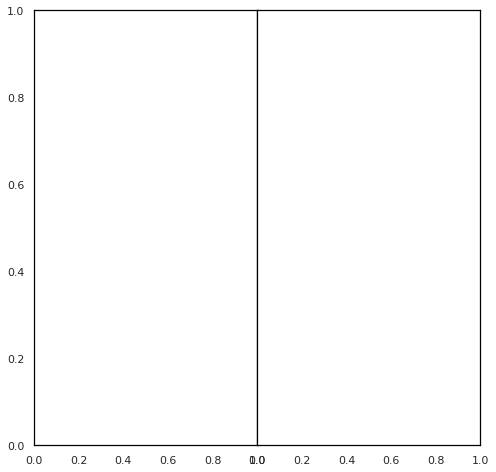

In [62]:
plot_households_distribution_side_to_side(data_household_noheader, bf_out_files, "D.pdf")

In [ ]:
def plot_input_role_age_distribution(data_households_role, box_name, box_aspect=None, force_stack_order=False, force_y_lim=False):
    df = get_role_age_dataframe(data_households_role)
    stacking_entries = get_age_strings()
    ax = set_aspect(box_aspect)
    ax = stacked_barplot(df, 'Role', stacking_entries, ax=ax, legend=True)
    ax = set_decoration_household_distribution(ax, title="Distribution of role - input", xlabel=True, force_y_lim=force_y_lim)
    format_and_save(box_name)
    
def get_role_age_dataframe(data_households_role, force_stack_order=False):
    df = pd.read_csv(data_households_role, header=3).drop(columns='Unnamed: 8')
    df = df.rename(columns={'Unnamed: 0': 'Description'})
    df = df.T
    header = df.iloc[0]
    df = df[1:]
    df = df.rename(columns=header)
    if force_stack_order: df = df[get_age_strings()]
    index_order = sorted(df.index)
    df = df.reindex(index_order)
    df = df.reset_index()
    df = df.rename(columns={'index': 'Role'})
    df['run'] = 0
    df = df.set_index('run')
    return df

def get_role_age_distribution_ax(df, box_aspect, palette='viridis',title=''):
    pal = sns.color_palette('viridis', df.shape[1])
    colors = pal.as_hex()
    ax = set_aspect(box_aspect)
    ax = df.plot.bar(stacked=True, color=colors, grid=True, ax=ax)
    locmaj = mticker.MultipleLocator(0.1)
    ax.yaxis.set_major_locator(locmaj)
    locmin = mticker.MultipleLocator(0.025)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    ax.yaxis.set_minor_formatter(mticker.FormatStrFormatter(''))
    ax.axes.grid(True,which="major",ls="-",c='gray',axis='y')
    ax.axes.grid(True,which="minor",ls="-",c='gray',alpha=0.4, axis='y')
    ax.set_title(title)
    ax.set_xlabel("Role")

    return ax


In [63]:
plot_input_role_age_distribution(data_households_role, 'G_in.pdf', force_stack_order=True, force_y_lim=False)

NameError: name 'plot_input_role_age_distribution' is not defined

In [64]:
def plot_role_age_matrix_output(bf_out_files, box_name, box_aspect=None, force_stack_order=False, force_y_lim=False):

    runs_df = get_role_stats_whole_simulation(bf_out_files, force_stack_order)
    stacking_entries = get_age_strings()
    ax = set_aspect(box_aspect)
    ax = stacked_barplot(runs_df, 'Role', stacking_entries, ax=ax, legend=True)
    ax = set_decoration_household_distribution(ax, title="Distribution of role - output", xlabel=True, force_y_lim=force_y_lim)
#     ax = get_role_age_distribution_ax(df, box_aspect, palette='viridis', title="Roles distribution - Output")
    format_and_save(box_name)

def get_role_stats_whole_simulation(bf_out_files, force_stack_order):
    runs_df = pd.DataFrame()
    for bf_out_file in bf_out_files:
        df = get_role_age_dataframe_output(bf_out_file, force_stack_order)
        df['run']=get_run_id(bf_out_file, 'BF')
        df = df.reset_index()
        df = df.set_index('run')
        runs_df = runs_df.append(df)
        
    return runs_df
    
def get_role_age_dataframe_output(bf_out_file, force_stack_order, make_frac=False):
    columns = ['agent_id', 'family_id', 'tile_id', 'age_group', 'Role', 'done_flag', 'parent_id', 'peer_id', 'child_1', 'child_2', 'child_3', 'child_4', 'child_5', 'num_c_ud']
    bf_df = pd.read_csv(bf_out_file, sep=' ', names=columns)
    families_df = bf_df[bf_df.done_flag == 1]
    group_names = get_age_strings()
    replaces = {strg[0]: strg for strg in group_names}
    families_df.rename(columns={"age_group": "Age Group"}, inplace=True)
    families_df.replace(to_replace=replaces, inplace=True)
    count_df = families_df.groupby(['Role', 'Age Group']).count().iloc[:, 0]
    if force_stack_order is True:
        sum_val = count_df.groupby('Age Group').sum().to_dict()
        count_df = count_df.reset_index()
        count_df['agent_id'] = count_df.apply(lambda x: normalize(x, sum_val), axis=1)
    else: count_df = count_df.reset_index()
    df = count_df.pivot('Role', 'Age Group', 'agent_id')
    if force_stack_order: df = df[get_age_strings()]
    index_order = sorted(df.index)
    df = df.reindex(index_order).fillna(0)

    return df

def normalize(x, sum_val):
    key = x['Age Group']
    sm = sum_val[key]
    return x.agent_id/sm

In [65]:
plot_role_age_matrix_output(bf_out_files, "G_out.pdf", force_stack_order=True)

KeyError: 'Role'

In [ ]:
def plot_households_distribution_side_to_side(data_households_role, bf_out_files, box_name, box_aspect=None, force_stack_order=True, force_y_lim=None):

    fig, axs = plt.subplots(1,2, sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0})
    (ax1, ax2)=axs

    if box_aspect is not None: ax1.set_aspect(box_aspect*2)
    if box_aspect is not None: ax2.set_aspect(box_aspect*2)

    df = get_role_age_dataframe(data_households_role)
    stacking_entries = get_age_strings()

    runs_df = get_role_stats_whole_simulation(bf_out_files, force_stack_order=True)
    stacking_entries = get_age_strings()

    ax1 = stacked_barplot(df, 'Role', stacking_entries, ax=ax1, legend=True)
    ax1 = set_decoration_household_distribution(ax1, title="Input", xlabel=True, force_y_lim=force_y_lim)
    ax2 = stacked_barplot(runs_df, 'Role', stacking_entries, ax=ax2, legend=True)
    ax2 = set_decoration_household_distribution(ax2, title="Output", xlabel=True, force_y_lim=force_y_lim)
    for ax in axs.flat:
            ax.label_outer()
    fig.suptitle("Distribution of Roles", fontsize=RC_GLOBAL["axes.titlesize"]*1.25)
    format_and_save(box_name)

KeyError: 'Type'

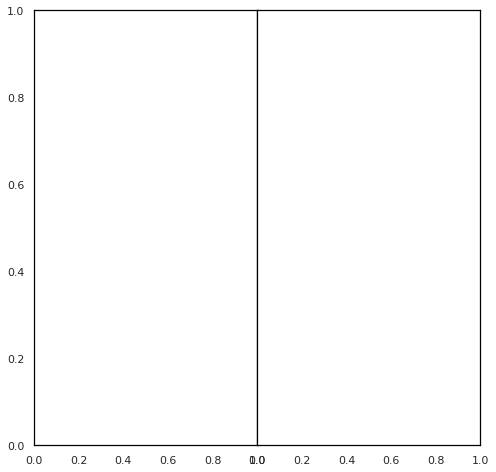

In [66]:
plot_households_distribution_side_to_side(data_households_role, bf_out_files, "G.pdf")

In [ ]:
def plot_input_data(data_config,data_pop,box_name, box_aspect=None):
    data = make_input_table(data_config,data_pop)
    if box_aspect is not None:
        render_mpl_table(data, width=1/box_aspect, font_size=10)
    else:
        render_mpl_table(data, font_size=10)
    format_and_save(box_name)
    
def render_mpl_table(data, width=None, height=None, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
        
    #If width is specified change default values

    if width is not None:
        num_columns = len(data.columns)
        width_no_restriction = num_columns*col_width
        aspetct_ratio=width/width_no_restriction
        col_width *= aspetct_ratio
        row_height *= aspetct_ratio
        
    #Make the table
        
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)
    
    #Write into the cells

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

def make_input_table(data_config, data_pop):
    
    #Make the table structure
    input_df = pd.DataFrame(columns=['Parameter', 'Value'])

    #Read the input values
        #1 - Population size
    size = read_from_config(data_config, 'POPULATION', 'size')
    if size == 0:
        size = str(pd.read_csv(data_pop).shape[0]) + '\n(the whole population)'
    input_df = input_df.append({
        'Parameter': 'Population Size',
         'Value': size
        }, ignore_index=True
    )
    
        #2 - Age stratification distribution mode
    groups = read_from_config(data_config, 'POPULATION', 'groups')
    input_df = input_df.append({
        'Parameter': 'Age-stratification\ndistribution mode',
         'Value': groups
        }, ignore_index=True
    )
        #3 - Fitness Function
    fitness_func = read_from_config(data_config, 'POPULATION', 'fitness_func')
    input_df = input_df.append({
        'Parameter': 'Fitness Function',
         'Value': fitness_func
        }, ignore_index=True
    )

        #4 - Household flag 
    household_flag = read_from_config(data_config, 'POPULATION', 'households')
    input_df = input_df.append({
        'Parameter': 'Household flag',
         'Value': household_flag
        }, ignore_index=True
    )
    
        #5 - Generator mode 
    generator = read_from_config(data_config, 'POPULATION', 'mode')
    if generator == 'reader':
        generator = generator + ' (the population\nwill be read from a csv file)'
    else:
        generator = generator + '(the population will be generated\nusing a pseudo random generator)'

    input_df = input_df.append({
        'Parameter': 'Generator',
         'Value': generator
        }, ignore_index=True
    )

        #6 - Distance Function
    dist_func = read_from_config(data_config, 'DISTANCES', 'dist_func')
    if dist_func == 'one': dist_func = dist_func + ' (the distance between any\ntwo nodes is set to 1)'
    if type(dist_func) is tuple: dist_func = 'euclidian power\nwith exponent= '+str(dist_func[1])
    input_df = input_df.append({
        'Parameter': 'Distance Function',
         'Value': dist_func
        }, ignore_index=True
    )

    mu = read_from_config(data_config, 'SOCIALITY', 'avg_deg')
    input_df = input_df.append({
        'Parameter': 'Avg degree',
         'Value': mu
        }, ignore_index=True
    )

    return input_df

In [67]:
plot_input_data(data_config,data_pop,"E.pdf")

./resources/E.pdf


In [68]:
def compute_g2g_matrix_abs(graph_data, territory, hh=True, groups_names = get_age_strings(), triangular=True):
    
    dimx ,dimy  = territory['ntiles']
    dim=dimx*dimy

    groups = [i for i in range(len(groups_names))]
    g1 = ig.read(graph_data)
    #print(np.unique(g1.es['layer']))

    hh_edges = [e for e in g1.es if "household" in e['layer']]
    fs_edges = [e for e in g1.es if "friendship" in e['layer']]

    if not hh:
        g1=g1.subgraph_edges(fs_edges, delete_vertices=True)

    edges = [g1.es[i].tuple for i in range(g1.ecount())]
    n=len(groups)
    m=len(edges)

    G=np.zeros((n,n))
    for idx, e in enumerate(edges):
        u  = e[0]
        v  = e[1]
        tv = g1.vs[v]['type'] 
        tu = g1.vs[u]['type']
        G[tu,tv]+=1.0
        G[tv,tu]+=0.0
        if not triangular: G[tv,tu]+=1.0
            
    run = []
    for tu in range(len(groups_names)):
        for tv in range(len(groups_names)):
            entry = [groups_names[tu], groups_names[tv], G[tv,tu]]
            run.append(entry)
    run = pd.DataFrame(run, columns=['nodeA', 'nodeB', 'links'])
    return run

def plot_g2g_matrix_output(graph_files, territory_data, city, box_name, box_aspect=None, triangular=True):
    with open(territory_data, "rb") as file:
        territory = pickle.load(file)
    groups_names=get_age_strings()
    runs_df = pd.DataFrame(columns=['nodeA', 'nodeB', 'links', 'run'])
    cumulative = np.zeros((len(groups_names), len(groups_names)))
    samples = len(graph_files)

    for graph_data in graph_files:
        run = compute_g2g_matrix_abs(graph_data, territory, True, triangular=False)
        run['run'] = get_run_id(graph_data, 'sb_graph')
        runs_df = runs_df.append(run) 
    mean_df = runs_df.groupby(['nodeA','nodeB']).mean()
    std_df = runs_df.groupby(['nodeA','nodeB']).std()

    fig, (ax1, ax2) = plt.subplots(1,2)

    perc_df = mean_df.div(mean_df.sum()).multiply(100)
    perc_std_df = std_df.div(mean_df.sum()).multiply(100)
    perc_df = perc_df.reset_index().pivot(index='nodeA', columns='nodeB', values='links')
    perc_std_df = perc_std_df.reset_index().pivot(index='nodeA', columns='nodeB', values='links')
    xl=groups_names
    yl=[groups_names[i] for i in range(len(groups_names)-1, -1, -1)]
    perc_df = perc_df[xl]
    perc_df = perc_df.reindex(index=yl)
    perc_std_df = perc_std_df[xl]
    perc_std_df = perc_std_df.reindex(index=yl)
    ax1=sns.heatmap(perc_df, cmap="viridis", annot = True, mask=perc_df==0., cbar=False, ax=ax1, square=True)
    ax1.tick_params(axis="x", rotation=50)
    ax1.set_xlabel("")
    ax1.set_ylabel("")
    ax1.set_title("Links mean")
    ax2=sns.heatmap(perc_std_df, cmap="viridis", annot = True, mask=perc_df==0., cbar=False, ax=ax2, square=True)
    ax2.tick_params(axis="x", rotation=50)
    ax2.set_xlabel("")
    ax2.set_ylabel("")
    ax2.set_title("Links standard deviation")
    fig.suptitle("Link between age groups (%) - output", fontsize=RC_GLOBAL["axes.titlesize"]*1.25)
    plt.tight_layout()


In [69]:
plot_g2g_matrix_output(graph_files, territory_data, city, "F.pdf", triangular=False)

IndexError: list index out of range

In [ ]:
def plot_household_stats_per_tile(bf_out_files, data_household_noheader, data_households_role, data_pop, box_name, box_aspect=None):

    #Get national household data
    household_national = process_household_stats_input(data_household_noheader, data_households_role, data_pop)
    
    #Get the household data of the whole simulation and calculate the relative error for each tile
    household_per_tile_df_runs = pd.DataFrame()
    ordered_index = None
    for bf_out_file in bf_out_files:
        household_per_tile_df, sum_values = get_tile_household_stats_frac(bf_out_file)
        if ordered_index is None: ordered_index = household_per_tile_df.index.to_list()
    #We give the dataframe an extra column regarding the run id
        household_per_tile_df['run']=get_run_id(bf_out_file, 'BF')
        household_per_tile_df_runs = household_per_tile_df_runs.append(household_per_tile_df)

    #Evaluation of the mean of each entry
    mean_df = household_per_tile_df_runs.reset_index().groupby('Tile').mean()
    #Here we evaluate the relative error, i.e (x_run - x_national)/x_national where x is the household 'col' fraction
    for col in mean_df.columns.to_list():
        mean_df[col] = (mean_df[col]-household_national[col])/household_national[col]
        
    mean_df['Cumulative'] = get_cumulative_population(sum_values)

    #Actual plot and decorations
    ax = set_aspect(box_aspect)
    mean_df = mean_df.sort_values(by=['Cumulative']) 
    g1 = sns.heatmap(mean_df.T,
                    cmap='Spectral',
                    xticklabels=True,
                    vmin=-1,
                    vmax=1,
                    cbar=True,
                    square=False,
                    linewidth=0.1,
                    ax=ax)
    #In this part we make sure that each mesh has its own Tile label
    Bbox = g1.get_position()
    rows = household_per_tile_df.shape[0]
    dx = (Bbox.x1 - Bbox.x0)/rows
    width, height = Bbox.width, Bbox.height
    fontsize = 100*dx*width*0.8
    
    #Other decorations
    g1.set_title("Households distribution per tile - output")
    g1.set_xlabel("Tile")
    g1.set_xticklabels(g1.get_xticklabels(),fontdict={'fontsize': fontsize})
    g1.set_ylabel("")
    
    #To check if the relative error is reduced in function of the tile's population, we plot
    #the cumulative population in function of the tile id as well.
    format_and_save(box_name)

def get_cumulative_population(sum_values, normalize=True, asseries=True):
    #Get the cumulative
    cumulative = sum_values.cumsum()
    if normalize is True: cumulative = cumulative.div(cumulative.max())
    if asseries is True: return cumulative
    
    #Preprocess the cumulative
    cumulative = cumulative.to_frame().reset_index()
    cumulative['Tile'] = cumulative['Tile'].astype(str)
    return cumulative

    
def get_tile_household_stats_frac(bf_out_file):
    #Read the data of the run
    bf_df = get_bf_out(bf_out_file)

    families_df_all_tiles = bf_df

    tile_household_stat = pd.DataFrame()
    
    #Aggregate data by tiles
    for tile in pd.unique(families_df_all_tiles.tile_id):
        entry = {}
        families_df = families_df_all_tiles[families_df_all_tiles.tile_id == tile]
        entry = get_household_stats_run(families_df)
        entry['Tile'] = tile
        tile_household_stat = tile_household_stat.append(entry, ignore_index=True)
        
    #Process the data by getting the franction of the household in each tile
    tile_household_stat = tile_household_stat.astype(int)
    tile_household_stat['sum'] = tile_household_stat[get_age_strings()].sum(axis=1)
    tile_household_stat = tile_household_stat.sort_values('sum', ascending=False)
    tile_household_stat = tile_household_stat.set_index('Tile')
    sum_values = tile_household_stat['sum']
    tile_household_stat_frac = tile_household_stat.drop(columns=get_age_strings() + ['sum'])
    tile_household_stat_frac = tile_household_stat_frac.div(tile_household_stat_frac.sum(axis=1), axis=0)

    return tile_household_stat_frac, sum_values

def process_household_stats_input(data_household_noheader, data_households_role, data_pop):
    df = pd.read_csv(data_household_noheader)
    entry = {}
    couples = df[df.Type=="C2"].Probability[1]
    entry['Couple'] = couples
    parents_in_couple =df[df.Description.str.match('Couple with')].Probability.sum()
    entry['Couple with child'] = parents_in_couple
    parents_no_partner = df[df.Description.str.match('Single parent')].Probability.sum()
    entry['Single parents'] = parents_no_partner
    singles=df[df.Description.str.match('Single person')].Probability.sum()
    entry['Single person'] = singles
    various=df[df.Description.str.match('Various')].Probability.sum()
    entry['Various'] = various
    return entry

In [ ]:
plot_household_stats_per_tile(bf_out_files, data_household_noheader, data_households_role, data_pop, "H.pdf")

In [ ]:
def plot_age_stats_per_tile(bf_out_files, data_pop, box_name, box_aspect=None):
    
    #Set the DataFrame
    ages_per_tile_df_runs = pd.DataFrame()
    
    #Get input ages fraction
    ages_input = pd.read_csv(data_pop).type.value_counts()  
    ages_city = {}
    pop=sum(ages_input)
    for n, age in enumerate(get_age_strings()):
        ages_city[age]=ages_input[n]
        ages_city[age] /= pop
        
    #Ordering index
    ordered_index = None
    
    #Make the output DataFrame with the relative error, i.e. (x_run - x_city)/x_city where x is age group
    for bf_out_file in bf_out_files:
        ages_per_tile_df, sum_values = get_tile_age_stats_frac(bf_out_file)
        if ordered_index is None: ordered_index = ages_per_tile_df.index.to_list()
        ages_per_tile_df['run']=get_run_id(bf_out_file, 'BF')
        ages_per_tile_df_runs = ages_per_tile_df_runs.append(ages_per_tile_df)
    
    #Evaluating the mean for each entry
    mean_df = ages_per_tile_df_runs.reset_index().groupby('Tile').mean()
    #Evaluating the relative error
    for col in mean_df.columns.to_list():
        mean_df[col] = (mean_df[col]-ages_city[col])/ages_city[col]

    fig, ax1 = plt.subplots()
    mean_df = mean_df.reindex(index=ordered_index)
    
    #Actual plot and decorations
    g = sns.heatmap(mean_df.T,
                    cmap='Spectral',
                    xticklabels=True,
                    vmin=-1,
                    vmax=1,
                    cbar=True,
                    square=False,
                    linewidth=0.1,
                    ax=ax1)
    
    g.set_title("Ages distribution per tile")
    g.set_xlabel("Tile")
    g.set_ylabel("")
    Bbox = g.get_position()
    rows = ages_per_tile_df.shape[0]
    dx = (Bbox.x1 - Bbox.x0)/rows
    width, height = Bbox.width, Bbox.height
    fontsize = 100*dx*width*0.8
    xticklist = g.get_xticklabels()
    yticklist = (string.get_text().title() for string in g.get_yticklabels())
    g.set_xticklabels(xticklist,fontdict={'fontsize': fontsize})
    g.set_yticklabels(yticklist,fontdict={'rotation': 'vertical'})
    #g2 = get_cumulative_population(sum_values, ax2)
    
    format_and_save(box_name)
    
def get_tile_age_stats_frac(bf_out_file):
    #Read the data
    bf_df = get_bf_out(bf_out_file)

    #Get the done actors only
    families_df_all_tiles = bf_df[bf_df.done_flag == 1]

    tile_age_stat = pd.DataFrame()
    
    #Get data by tile
    for tile in pd.unique(families_df_all_tiles.tile_id):
        entry = {}
        families_df = families_df_all_tiles[families_df_all_tiles.tile_id == tile]
        entry = get_age_stats_run(families_df)
        entry['Tile'] = tile
        tile_age_stat = tile_age_stat.append(entry, ignore_index=True)
        
    #Process each entry by getting the fraction of different ages per Tile
    tile_age_stat = tile_age_stat.astype(int)
    tile_age_stat['sum'] = tile_age_stat[get_age_strings()].sum(axis=1)
    tile_age_stat = tile_age_stat.sort_values('sum', ascending=False)
    tile_age_stat = tile_age_stat.set_index('Tile')
    sum_values = tile_age_stat['sum']
    tile_age_stat = tile_age_stat.drop(columns=['sum'])
    tile_age_stat = tile_age_stat.div(tile_age_stat.sum(axis=1), axis=0)
    return tile_age_stat, sum_values

def get_age_stats_run(families_df):
    entry = {}
    for age_index in range(len(get_age_strings())):
        age_string = get_age_strings()[age_index]
        age_actors = families_df[(families_df.age_group == age_string[0]) & (families_df.done_flag == 1)].shape[0]
        entry[age_string] = age_actors
    
    return entry

In [ ]:
plot_age_stats_per_tile(bf_out_files, data_pop, "K.pdf")

In [ ]:
def plot_population_density_heatmap(data_pop, territory_data, box_name, box_aspect=None, annot_tile=False):

    with open(territory_data, "rb") as file:
        territory = pickle.load(file)
    pop_df_array = pd.read_csv(data_pop)
    pop_x_array = pop_df_array.x
    pop_y_array = pop_df_array.y
    pop2d = build_pop_histo2d(territory, pop_x_array, pop_y_array)
    fig, ax = plt.subplots()
    if annot_tile:
        annot_param = get_annot_tile(territory)
        fmt = 'd'
    else:
        annot_param = True
        fmt='.2g'
    ntx, nty = territory['ntiles']
    if box_aspect is not None:
        ax.set_aspect(box_aspect)
    g = sns.heatmap(pop2d.T,
                    xticklabels=False,
                    yticklabels=False,
                    annot=annot_param,
                    square=True,
                    ax=ax,
                    mask=pop2d.T<1,
                    fmt=fmt,
                    cmap="viridis")
    g.set_title("Population per tile - input")
    g.set_ylim(0, nty)
    g.set_xlim(0, ntx)
    g.get_position()
    format_and_save(box_name)
    return

def build_pop_histo2d(territory, pop_x_array, pop_y_array):
    """ Compute a 2d histogram of the population nodes 
        on the territory using the grid tiles as histogram bins.
        This is used just for debugging purposes.
    """

    # Get the 2d histogram
    xedges, yedges = get_territory_hist_edges(territory)
    pop2d, xedges, yedges = np.histogram2d(pop_x_array, pop_y_array, [xedges, yedges])
    
    return pop2d

def get_territory_hist_edges(territory):
    # Get input var from territory
    x0 , y0  = territory['origin']
    ntx, nty = territory['ntiles']
    tx , ty  = territory['tile']
    # Compute bin edges 
    xedges = [x0 + i*tx for i in range(ntx+1)]
    yedges = [y0 + i*ty for i in range(nty+1)]
    return xedges, yedges

def get_annot_tile(territory):
    ntx, nty = territory['ntiles']
    annot_tile = []
    for row in range(nty):
        y = row
        row_entry = [y*ntx+x for x in range(ntx)] 
        annot_tile += [row_entry]
    return annot_tile

In [ ]:
plot_population_density_heatmap(data_pop, territory_data, "J.pdf", annot_tile=True)

In [38]:
def plot_avg_degree_heatmap(graph_files, territory_data, city, box_name, annot_tile=False, box_aspect=None):

    with open(territory_data,"rb") as file:
        territory = pickle.load(file)
    ntx ,nty  = territory['ntiles']
    nt=int(ntx*nty)
    samples = len(graph_files)
    deg_run = pd.DataFrame()

    for graph_data in graph_files:
        g = ig.read(graph_data)
        edges = [g.es[i].tuple for i in range(g.ecount())]
        avg_deg = np.zeros(nt)
        persons_per_tile = np.zeros(nt)

        for idx, e in enumerate(edges):
            u = e[0]
            v = e[1]
            tv = g.vs[v]['tile_id'] 
            tu = g.vs[u]['tile_id']
            avg_deg[tu]+=1
            avg_deg[tv]+=1

        for tile in g.vs['tile_id']:
            persons_per_tile[tile] += 1
        avg_deg = avg_deg/persons_per_tile
        entry = pd.Series(avg_deg).to_frame().reset_index()
        entry = entry.rename(columns={'index': 'tile', 0: 'avg'})
        entry['run']=get_run_id(graph_data, 'sb_graph') 
        deg_run = deg_run.append(entry)
        
    deg_run = deg_run.dropna(how='any')
    mean_df = deg_run.groupby('tile').mean().reset_index()
    std_df = deg_run.groupby('tile').std().reset_index()
    mean_df['ntx'] = mean_df['tile']%ntx 
    mean_df['nty'] = mean_df['tile']/ntx
    mean_df['nty'] = mean_df['nty'].astype(int)
    std_df['ntx'] = std_df['tile']%ntx 
    std_df['nty'] = std_df['tile']/ntx
    std_df['nty'] = std_df['nty'].astype(int)
    
    mean_df = mean_df.pivot(index='nty', columns='ntx', values='avg')
    std_df = std_df.pivot(index='nty', columns='ntx', values='avg')
    if annot_tile:
        annot_param = get_annot_tile(data)
        fmt = 'd'
    else:
        annot_param = True
        fmt='.2g'
        
    mean_df = mean_df.sort_index(ascending=False)    
    std_df = std_df.sort_index()    

    fig, (ax1, ax2) = plt.subplots(1,2)
    g1 = sns.heatmap(mean_df,
                    xticklabels=False,
                    yticklabels=False,
                    annot=annot_param,
                    square=True,
                    cmap="viridis",
                    mask=mean_df==0,
                   ax=ax1,
                   fmt=fmt,
                    cbar_kws={"orientation": "horizontal"},
                    annot_kws={'fontsize': '10'})
    
    g1.set_xlabel("")
    g1.set_ylabel("")
    ax1.set_title("Mean")
    g2 = sns.heatmap(std_df,
                    xticklabels=False,
                    yticklabels=False,
                    annot=annot_param,
                    square=True,
                    cmap="viridis",
                    mask=std_df==0,
                   ax=ax2,
                   fmt=fmt,
                    cbar_kws={"orientation": "horizontal"},
                    annot_kws={'fontsize': '10'})
    ax2.set_title("Standard deviation")
    g2.set_xlabel("")
    g2.set_ylabel("")
    fig.suptitle("Average degree per tile - output", fontsize=RC_GLOBAL["axes.titlesize"]*1.25)
    plt.ylim(0, nty)
    plt.xlim(0, ntx)
    plt.tight_layout()
    format_and_save(box_name)

In [39]:
plot_avg_degree_heatmap(graph_files, territory_data, city, "L.pdf", annot_tile=False)

ValueError: could not convert string to float: 'N'

In [40]:
def plot_avg_deg_per_age_group(graph_files, box_name, box_aspect=None):
    deg_type_run = pd.DataFrame()
    for graph_data in graph_files:
        graph = ig.read(graph_data)
        group_names = get_age_strings()

        groups = [i for i in range(len(group_names))]
        n=len(groups)

        d = {}
        i = 0
    
        for node in graph.vs:
            deg = node.degree()
            typ = node['type']
            d[i] = {'type': group_names[typ].title(), 'deg': deg}
            i = i+1
        deg_type = pd.DataFrame.from_dict(d, 'index')
        deg_type_run = deg_type_run.append(deg_type)
    ax = set_aspect(box_aspect)
    g = sns.boxplot(data=deg_type, x='type', y='deg', palette='viridis', ax=ax)
    locmaj = mticker.MultipleLocator(10)
    g.yaxis.set_major_locator(locmaj)
    g.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
    # locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=1)
    g.set_title("Average degree per age group - output")
    g.axes.grid(True,which="major",ls="-",c='gray',axis='y')
    format_and_save(box_name)


In [41]:
plot_avg_deg_per_age_group(graph_files, "R.pdf")

ValueError: could not convert string to float: 'N'

In [42]:
def plot_community_size_distribution(graph_files, box_name, density=False, box_aspect=None):
    run_df = pd.DataFrame()
    for graph_data in graph_files:
        entry = pd.DataFrame()
        graph = ig.read(graph_data)
        communities_len = graph.community_multilevel().membership
        hist, bins = process_histogram(communities_len, density=density)
        df = pd.DataFrame({'size': bins, 'count': hist})
        df['run_id']=get_run_id(graph_data, 'sb_graph')
        run_df = run_df.append(df)
        
    ax = set_aspect(box_aspect)
    g = sns.lineplot(data=run_df, x='size', y='count')
    plt.grid(True,which="minor",ls="--",c='gray', alpha=0.4)  
    plt.grid(True,which="major",ls="-",c='gray')  
    g.set_yscale('log')
    g.set_xscale('log')
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=10)  
    g.yaxis.set_minor_locator(locmin)
    g.yaxis.set_minor_formatter(mticker.NullFormatter())
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=1)  
    g.xaxis.set_minor_locator(locmin)
    g.xaxis.set_minor_formatter(mticker.NullFormatter())
    g.set_title("Communities size - output")
    if density is True: g.set_ylabel("Probability")
    else: g.set_ylabel("Count")
    g.set_xlabel("Community size")
    format_and_save(box_name)
    
def process_histogram(array, density, step=1):
    binMax = max(array)
    binMin = min(array)
    bins = np.arange(start=binMin, stop=binMax+1, step=step)
    hist, bins = np.histogram(array, bins=bins, density=density)
    bins = np.delete(bins, -1)
    return hist, bins


In [43]:
plot_community_size_distribution(graph_files, "M.pdf", density=False)

ValueError: could not convert string to float: 'N'

In [46]:
def plot_degree_distribution(graph_files, box_name, density=False, box_aspect=None):
    run_df = pd.DataFrame()
    for graph_data in graph_files:
        graph = ig.read(graph_data)
        degree_data = graph.degree()
        hist, bins = process_histogram(degree_data, density)
        df = pd.DataFrame({'degree': bins, 'count': hist})
        df['run'] = get_run_id(graph_data, 'sb_graph')
        run_df = run_df.append(df)
    ax = set_aspect(box_aspect)
    g = sns.lineplot(data=df, x='degree', y='count', ax=ax, palette='viridis')
    plt.grid(True,which="minor",ls="--",c='gray', alpha=0.4)  
    plt.grid(True,which="major",ls="-",c='gray')  
    g.set_yscale('log')
    g.set_xscale('log')
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=10)  
    g.yaxis.set_minor_locator(locmin)
    g.yaxis.set_minor_formatter(mticker.NullFormatter())
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=1)  
    g.xaxis.set_minor_locator(locmin)
    g.xaxis.set_minor_formatter(mticker.NullFormatter())
    g.set_title("Degree distribution - output")
    if density is True: g.set_ylabel("Probability")
    else: g.set_ylabel("Count")
    format_and_save(box_name)

In [47]:
plot_degree_distribution(graph_files, "N.pdf", density=True)

../data/graphs/firenze/deg10_ep05_1000m_min10pop/igraph_degree_distrib.txt


ValueError: could not convert string to float: 'N'

In [ ]:
def plot_distance_distribution(graph_files, box_name, density=False, box_aspect=None):
    runs_df = pd.DataFrame()
    for graph_data in graph_files:    
        graph = ig.read(graph_data)
        distance_data = graph.es['distance']
        hist, bins = process_histogram(distance_data, density=True)
        df = pd.DataFrame({'distance': bins, 'count': hist})
        df['run'] = get_run_id(graph_data, 'sb_graph')
        runs_df = runs_df.append(df)
    runs_df = runs_df[runs_df['count']!=0]
    ax = set_aspect(box_aspect)
    g = sns.lineplot(data=runs_df, x='distance', y='count', palette='viridis')
    g.set_yscale('log')
    g.set_xscale('log')
    plt.grid(True,which="minor",ls="--",c='gray', alpha=0.4)  
    plt.grid(True,which="major",ls="-",c='gray')  
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=10)  
    g.yaxis.set_minor_locator(locmin)
    g.yaxis.set_minor_formatter(mticker.NullFormatter())
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=1)
    xmin=10**int(np.log10(min(df.distance)))
    g.xaxis.set_minor_locator(locmin)
    g.xaxis.set_minor_formatter(mticker.NullFormatter())
    g.set_title("Distance Distribution - output")
    g.set_xlabel("Distance [m]")
    if density is True: g.set_ylabel("Probability")
    else: g.set_ylabel("Count")
    g.set_xlim(xmin, None)
    format_and_save(box_name)

In [ ]:
plot_distance_distribution(graph_files, "O.pdf")

In [ ]:
def plot_metrics(graph_files, box_name, box_aspect=None):
    metric_whole_simulation = pd.DataFrame()
    for graph_data in graph_files:
        g = ig.read(graph_data)
        metric = get_metrics(g)
        metric['run'] = get_run_id(graph_data, 'sb_graph')
        metric_whole_simulation = metric_whole_simulation.append(metric)
    
    mean_df = metric_whole_simulation.groupby('metrics').mean().reset_index()
    std_df = metric_whole_simulation.groupby('metrics').std().reset_index()
    
    plot_df = pd.DataFrame()
    plot_df['Metric'] = get_metrics(g)['metrics']
    plot_df['Values'] = mean_df['values'].apply(lambda x: '{:.1e}'.format(x)) + ' ± ' + std_df['values'].apply(lambda x: '{:f}'.format(x))
    
    ax = set_aspect(box_aspect)
    render_mpl_table(plot_df, ax=ax)
    format_and_save(box_name)
    
def get_metrics(graphs):
    vcount    = graphs.vcount()
    ecount    = graphs.ecount()
    density   = round( (2*ecount)/(vcount*(vcount-1)), 4)
    avgdeg    = round(2*ecount/vcount, 2)
    globalC   = round(graphs.transitivity_undirected(mode="zero"), 4)
    avglocC   = round(graphs.transitivity_avglocal_undirected(mode="zero"), 4)
    degAssort = round(graphs.assortativity_degree(directed=False), 4)
    cc        = graphs.components(mode=ig.WEAK)
    numCC     = len(cc)
    sizeGCC   = len(cc.giant().vs)
    columns = ['Nodes', 'Edges', 'Density', 'Average Degree', 'globalC', 'avglocC', 'Assortativity', 'Components', 'Size of Giant\nComponent']
    metrics = [vcount, ecount, density, avgdeg, globalC, avglocC, degAssort, numCC, sizeGCC]
    df = pd.DataFrame()
    df['metrics']=columns
    df['values']=metrics
    return df

In [ ]:
plot_metrics(graph_files, "P.pdf")

In [ ]:
def plot_adjmatrix(graph_data, box_name, box_aspect=None, point_size=0.1, point_color="Navy", hh=True, graph_file='sb_graph.pickle', ntiles = {'firenze':(15, 12), 'sabaudia':(16, 20), 'viterbo':(26, 32), 'vo':(6, 6)}):
        
    rng = np.random.default_rng()

    # Get graph and adjacency
    g1 = ig.read(graph_data)
    m  = get_igraph_adjacency(g1)
    N  = g1.vcount()
        
    hh_edges = [e for e in g1.es if "household" in e['layer']]
    fs_edges = [e for e in g1.es if "friendship" in e['layer']]
    print("num hh edges: {}, num fs edges; {}".format(len(hh_edges), len(fs_edges)))
    print("Use households =", hh)

    if not hh:
        g1=g1.subgraph_edges(fs_edges, delete_vertices=True)
    print(g1.summary())
    
    # ADJMATRIX
    # Per come è costuito il grafo devo fare il sort su v perchè in u potrebbero non esserci tutti i tipi
    edges = [g1.es[i].tuple for i in range(g1.ecount())]
    edges.sort(key=lambda x: x[1])
    #len(edges), type(edges), edges[0]

    # Trovo il numero di vertici dello stesso tipo
    typev=-1
    a = []

    attrib = 'type'
    for idx, e in enumerate(edges):
        u = e[0]
        v = e[1]
        #print(e, g1.vs[u]['type'],g1.vs[v]['type'])
        if g1.vs[v][attrib] != typev:
            typev = g1.vs[v][attrib]
            a.append(idx)

    # Permuto gli archi a gruppi e creo gli array per il plot
    x,y=zip(*edges)

    plist = [0]*len(a)
    for i in range(len(a)-1):
        plist[i] = rng.permutation(np.arange(a[i],a[i+1])).tolist()
        #print(i, a[i], a[i+1])
    plist[i+1]=rng.permutation(np.arange(a[i+1],len(x))).tolist()
    #all_perm=[u for perm in plist for u in perm]
    #print(len(all_perm))
    perm_array = np.concatenate(plist)
    x = np.array(x)
    x = x[perm_array]
    x = x.tolist()
    y = np.array(y)
    #y = y[perm_array]
    y = y.tolist()

    xx=x+y
    yy=y+x
    
    fig = plt.figure()
    if box_aspect is not None: ax = set_aspect(box_aspect)
    else:
        ax = fig.add_subplot(111, facecolor='white')
        ax.set_aspect('equal')
    ax.plot(xx, yy, 's', color=point_color, ms=point_size)
    ax.set_title("Adjacency matrix - output")
    #plt.axis('off')
    format_and_save(box_name)

def get_igraph_adjacency(g):
    if g.is_directed():
        data = np.ones(g.ecount())
    else:
        data = np.ones(2*g.ecount())
    indptr = [0]
    indices = []
    
    for adjl in g.get_adjlist():
        indices.extend(adjl)
        indptr.append(len(indices))
        
    A = csr_matrix((data,indices,indptr), shape=(g.vcount(),g.vcount()))
    return A

In [ ]:
graph_data = graph_files[0]
plot_adjmatrix(graph_data, "Q.pdf")